# Plots

## Imports

In [58]:
import sys
import os
import torch
import numpy as np
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)
from ssast_model import ASTModel
import soundfile as sf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import qrcode
import torchaudio
import pickle
import librosa

In [59]:
# Setting global parameters for Matplotlib to use LaTeX rendering
plt.rcParams.update({
    'text.usetex': True,  # Enable LaTeX rendering
    'text.latex.preamble': r'\usepackage{lmodern}\usepackage{amsmath}',  # Use Latin Modern font and include amsmath
    'font.family': 'serif',  # Use serif font for consistency with LaTeX document
    'font.serif': ['Latin Modern Roman'],  # Specify Latin Modern Roman
    'pdf.fonttype': 42,  # Ensures fonts are embedded as TrueType
    'savefig.dpi': 400,  # Lower DPI setting for non-text elements
    'font.size': 8.5,  # Adjust font size to match document (you may need to tweak this)
    'axes.labelsize': 8.5,  # Size of the x and y labels
    'axes.titlesize': 10.0,  # Size of the plot title
    'xtick.labelsize': 7.0,  # Size of the x-axis tick labels
    'ytick.labelsize': 7.0,  # Size of the y-axis tick labels
    'legend.fontsize': 8.5,  # Size of the legend font
    'figure.titlesize': 12.0  # Size of the figure's main title if any
})

## Spectrogram

Time of last sample: 9.9999375
Number of samples: 160000
Sample rate: 16000
Duration of audio: 10.0
Shape of audio signal: (160000,)
Type of audio signal: <class 'numpy.ndarray'>
Data type of audio signal: float64
Type of audio tensor: <class 'torch.Tensor'>
Data type of audio tensor: torch.float64
Shape of audio tensor: torch.Size([160000])
Data type of audio tensor: torch.float32
Shape of audio tensor: torch.Size([1, 160000])
Shape of fbank features: torch.Size([998, 128])


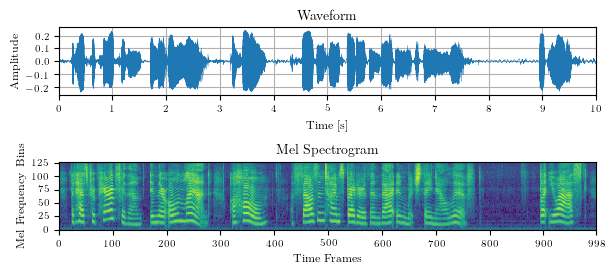

In [60]:
# Verify the file path is correct
file_path = '/home/bosfab01/SpeakerVerificationBA/data/preprocessed/0a4b5c0f-facc-4d3b-8a41-bc9148d62d95/0_segment_0.flac'
try:
    audio_signal, sample_rate = sf.read(file_path)
except Exception as e:
    print(f"An error occurred while reading the file: {e}")
    raise

# Create time array for plotting
time = np.arange(len(audio_signal)) / sample_rate

# Print information about the audio
print("Time of last sample:", time[-1])
print("Number of samples:", len(audio_signal))
print("Sample rate:", sample_rate)
print("Duration of audio:", len(audio_signal) / sample_rate)
print("Shape of audio signal:", audio_signal.shape)
print("Type of audio signal:", type(audio_signal))
print("Data type of audio signal:", audio_signal.dtype)


# Convert the NumPy array to a PyTorch tensor
audio_tensor = torch.from_numpy(audio_signal)
print("Type of audio tensor:", type(audio_tensor))
print("Data type of audio tensor:", audio_tensor.dtype)
print("Shape of audio tensor:", audio_tensor.shape)

# Ensure the tensor is in float32 format (required for most torchaudio operations)
audio_tensor = audio_tensor.float()
print("Data type of audio tensor:", audio_tensor.dtype)

# If your array is not in batch x channels x time format, adjust accordingly
# Assuming the audio signal is single-channel and not batched:
audio_tensor = audio_tensor.unsqueeze(0)
print("Shape of audio tensor:", audio_tensor.shape)

# Now call the fbank function
fbank_features = torchaudio.compliance.kaldi.fbank(
    audio_tensor, 
    sample_frequency=sample_rate, 
    htk_compat=True, 
    use_energy=False, 
    window_type='hanning', 
    num_mel_bins=128, 
    dither=0.0, 
    frame_shift=10
)

# Output the shape of the fbank features to confirm
print(f"Shape of fbank features: {fbank_features.shape}")

# Function to plot spectrogram
def plot_spectrogram(spectrogram, ax, title="Mel Spectrogram"):
    # Assuming spectrogram data is on a tensor and needs to be moved to CPU and converted to numpy array
    ax.imshow(spectrogram.T.cpu().numpy(), aspect='auto', origin='lower', cmap='viridis', interpolation='none')
    ax.set_title(title)
    ax.set_xticks(np.concatenate((np.arange(0, 1000, 100), [spectrogram.shape[0]])))
    ax.set_yticks(np.arange(0, 150, 25))
    ax.set_xlabel('Time Frames')
    ax.set_ylabel('Mel Frequency Bins')

def plot_spectrogram_mesh(spectrogram, ax, title="Spectrogram"):
    # Convert tensor to numpy if necessary
    data = spectrogram.T.cpu().numpy()
    # Create a meshgrid for the x and y dimensions
    x = np.linspace(0, data.shape[1], data.shape[1])
    y = np.linspace(0, data.shape[0], data.shape[0])
    X, Y = np.meshgrid(x, y)
    # Use pcolormesh to plot data
    pcm = ax.pcolormesh(X, Y, data, shading='auto', cmap='viridis')
    ax.set_title(title)
    ax.set_xticks(np.concatenate((np.arange(0, 1000, 100), [spectrogram.shape[0]])))
    ax.set_yticks(np.arange(0, 150, 25))
    ax.set_xlabel('Time Frames')
    ax.set_ylabel('Mel Frequency Bins')
    # Optionally add a colorbar
    #plt.colorbar(pcm, ax=ax)

# Create a figure with two subplots, one above the other
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.2, 2.8))  # Adjust total figure size as needed

# Plot the audio signal
ax1.plot(time, audio_signal, linewidth=0.2)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Amplitude')
ax1.set_xticks(np.arange(0, 11, 1))
ax1.set_yticks(np.arange(-0.2, 0.3, 0.1))
ax1.set_xlim([0, 10])
ax1.set_title('Waveform')
ax1.grid(True)

# Plot the fbank features using the defined function
plot_spectrogram(fbank_features, ax2)

# Adjust layout so plots do not overlap
plt.tight_layout()

# Save the figure as a PDF file
directory = 'plots'
if not os.path.exists(directory):
    os.makedirs(directory)
plt.savefig("plots/waveform_spectrogram.pdf")

# Show the figure
plt.show()

## Pretraining

### Loss

#### shuffled frames

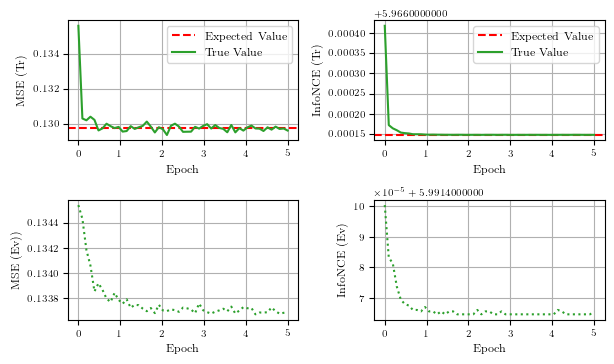

In [61]:
# Load the progress and result data
path_shuffled = '../pretraining/exp/pretrained-20240429-112534-shuffled-base-f128-t2-b48-lr1e-4-m390-pretrain_joint-asli'
with open(os.path.join(path_shuffled, 'progress.pkl'), 'rb') as f:
    progress_shuffled = pickle.load(f)
iteration_shuffled = np.array([x[1] for x in progress_shuffled])
epoch_shuffled = np.linspace(0, 5, len(iteration_shuffled))
result_shuffled = np.genfromtxt(os.path.join(path_shuffled, 'result.csv'), delimiter=',')

def get_column(array):
    for i in range(array.shape[1]):
        yield array[:, i]

acc_tr_shuffled, loss1_tr_shuffled, loss2_tr_shuffled, acc_ev_shuffled, loss1_ev_shuffled, loss2_ev_shuffled, lr_shuffled = get_column(result_shuffled)

# Define expected values
expected_mse = 0.129726
expected_infoNCE = 5.966147

# Setup the plot
fig, axs = plt.subplots(2, 2, figsize=(6.2, 3.7))
color_shuffled = 'tab:green'

# Plot training and evaluation data with horizontal lines for expected values
axs[0, 0].axhline(y=expected_mse, color='r', linestyle='--', label=f'Expected Value')
axs[0, 0].plot(epoch_shuffled, loss2_tr_shuffled, color=color_shuffled, label='True Value')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('MSE (Tr)')
axs[0, 0].legend()
axs[0, 0].grid()

axs[1, 0].plot(epoch_shuffled, loss2_ev_shuffled, color=color_shuffled, linestyle='dotted')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('MSE (Ev))')
axs[1, 0].grid()

axs[0, 1].axhline(y=expected_infoNCE, color='r', linestyle='--', label=f'Expected Value')
axs[0, 1].plot(epoch_shuffled, loss1_tr_shuffled, color=color_shuffled, label='True Value')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('InfoNCE (Tr)')
axs[0, 1].legend()
axs[0, 1].grid()

# Plot for learning rate
axs[1, 1].plot(epoch_shuffled, loss1_ev_shuffled, color=color_shuffled, linestyle='dotted')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('InfoNCE (Ev)')
axs[1, 1].grid()

plt.tight_layout()
directory = 'plots'
if not os.path.exists(directory):
    os.makedirs(directory)
plt.savefig('plots/pretraining_shuffledModel.pdf')
plt.show()

#### original frames compared to gong

rows orig:	 107 ;		columns orig:	 7
rows gong:	 199 ;		columns gong:	 5


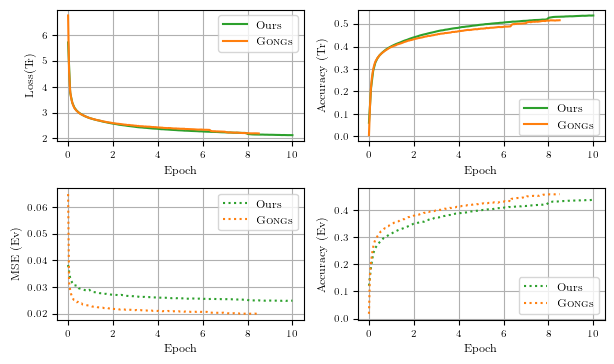

In [62]:
# Load the progress and result data
path_original = '../pretraining/exp/pretrained-20240501-162648-original-base-f128-t2-b48-lr1e-4-m390-pretrain_joint-asli'
with open(os.path.join(path_original, 'progress.pkl'), 'rb') as f:
    progress_original = pickle.load(f)
iteration_original = np.array([x[1] for x in progress_original])
epoch_original = np.linspace(0, 10, len(iteration_original))
result_original = np.genfromtxt(os.path.join(path_original, 'result.csv'), delimiter=',')


# Load Gong's model
relative_path_gong = 'pretraining/result_gong.csv'
path_gong = os.path.join(parent_directory, relative_path_gong)
result_gong = np.genfromtxt(path_gong, delimiter=',')

print("rows orig:\t", result_original.shape[0], ";\t\tcolumns orig:\t", result_original.shape[1])
print("rows gong:\t", result_gong.shape[0], ";\t\tcolumns gong:\t", result_gong.shape[1])

def get_column(array):
    for i in range(array.shape[1]):
        yield array[:, i]

acc_tr_original, loss1_tr_original, loss2_tr_original, acc_ev_original, loss1_ev_original, loss2_ev_original, lr_original = get_column(result_original)
acc_tr_gong, loss_tr_gong, acc_ev_gong, mse_ev_gong, lr_gong = get_column(result_gong)
iteration_gong = np.arange(1, len(acc_tr_gong)+1) * 4000
epoch_gong = np.linspace(0, 8.5, len(iteration_gong))

# Setup the plot
fig, axs = plt.subplots(2, 2, figsize=(6.2, 3.7))
color_original = 'tab:green'
color_gong = 'tab:orange'

axs[0, 0].plot(epoch_original, loss1_tr_original + 10*loss2_tr_original, color=color_original, label='Ours')
axs[0, 0].plot(epoch_gong, loss_tr_gong, color=color_gong, label=r'\textsc{Gong}s')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss(Tr)')
axs[0, 0].legend()
axs[0, 0].grid()

axs[1, 0].plot(epoch_original, loss2_ev_original, color=color_original, linestyle='dotted', label='Ours')
axs[1, 0].plot(epoch_gong, mse_ev_gong, color=color_gong, linestyle='dotted', label=r'\textsc{Gong}s')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('MSE (Ev)')
axs[1, 0].legend()
axs[1, 0].grid()

axs[0, 1].plot(epoch_original, acc_tr_original, color=color_original, label='Ours')
axs[0, 1].plot(epoch_gong, acc_tr_gong, color=color_gong, label=r'\textsc{Gong}s')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Accuracy (Tr)')
axs[0, 1].legend()
axs[0, 1].grid()

axs[1, 1].plot(epoch_original, acc_ev_original, color=color_original, linestyle='dotted', label='Ours')
axs[1, 1].plot(epoch_gong, acc_ev_gong, color=color_gong, linestyle='dotted', label=r'\textsc{Gong}s')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Accuracy (Ev)')
axs[1, 1].legend()
axs[1, 1].grid()

plt.tight_layout()
directory = 'plots'
if not os.path.exists(directory):
    os.makedirs(directory)
plt.savefig('plots/pretraining_comparison_Gong.pdf')
plt.show()

#### original frames

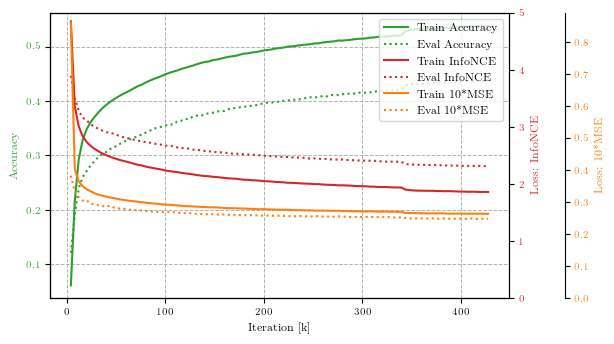

In [63]:
# Visualize the training progress
fig, ax1 = plt.subplots(figsize=(6.2, 3.5))

# set title
#fig.suptitle('Pretraining Progress')

color_acc = 'tab:green'
ax1.set_xlabel('Iteration [k]')
ax1.set_ylabel('Accuracy', color=color_acc)
line1, = ax1.plot(iteration_original / 1e3, acc_tr_original, color=color_acc, label='Train Accuracy')
line2, = ax1.plot(iteration_original / 1e3, acc_ev_original, color=color_acc, linestyle='dotted', label='Eval Accuracy')
ax1.tick_params(axis='y', labelcolor=color_acc)
#ax1.set_ylim(0, 1)

ax2 = ax1.twinx()
color_InfoNCE = 'tab:red'
ax2.set_ylabel('Loss: InfoNCE', color=color_InfoNCE)
line3, = ax2.plot(iteration_original / 1e3, loss1_tr_original, color=color_InfoNCE, label='Train InfoNCE')
line4, = ax2.plot(iteration_original / 1e3, loss1_ev_original, color=color_InfoNCE, linestyle='dotted', label='Eval InfoNCE')
ax2.tick_params(axis='y', labelcolor=color_InfoNCE)
ax2.set_ylim(0, ax2.get_ylim()[1])

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 40))
color_10MSE = 'tab:orange'
ax3.set_ylabel('Loss: 10*MSE', color=color_10MSE)
line5, = ax3.plot(iteration_original / 1e3, loss2_tr_original*10, color=color_10MSE, label='Train 10*MSE')
line6, = ax3.plot(iteration_original / 1e3, loss2_ev_original*10, color=color_10MSE, linestyle='dotted', label='Eval 10*MSE')
ax3.tick_params(axis='y', labelcolor=color_10MSE)
ax3.set_ylim(0, ax3.get_ylim()[1])

# Adding grid to the primary axis (ax1)
ax1.grid(True, which='both', linestyle='--', linewidth=0.7)

# Collect all lines and labels for the legend
lines = [line1, line2, line3, line4, line5, line6]
labels = [line.get_label() for line in lines]

# After your plotting code, to adjust the legend:
all_axes = fig.get_axes()
for axis in all_axes:
    legend = axis.get_legend()
    if legend is not None:
        legend.remove()
        all_axes[-1].add_artist(legend)

# Place a single legend on the plot
ax3.legend(lines, labels, loc='best')

plt.tight_layout()


directory = 'plots'
if not os.path.exists(directory):
    os.makedirs(directory)
#plt.savefig('plots/pretraining_progress.pdf')

plt.show()

### visualize the masked spectrogram, the reconstructed spectrogram, and the original spectrogram

Time of last sample: 9.9999375
Number of samples: 160000
Sample rate: 16000
Duration of audio: 10.0
Shape of audio signal: (160000,)
Type of audio signal: <class 'numpy.ndarray'>
Data type of audio signal: float64
Type of audio tensor: <class 'torch.Tensor'>
Data type of audio tensor: torch.float64
Shape of audio tensor: torch.Size([160000])
Data type of audio tensor: torch.float32
Shape of audio tensor: torch.Size([1, 160000])
Shape of fbank features: torch.Size([998, 128])
Shape of fbank features: torch.Size([1, 998, 128])
pretraining patch split stride: frequency=128, time=2
pretraining patch shape: frequency=128, time=2
pretraining patch array dimension: frequency=1, time=499
pretraining number of patches=499
cpu
range(50, 489, 50)
[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156

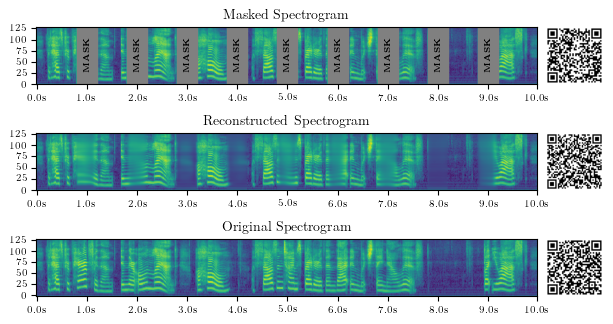

In [64]:
# Verify the file path is correct
file_path = '/home/bosfab01/SpeakerVerificationBA/data/preprocessed/0a4b5c0f-facc-4d3b-8a41-bc9148d62d95/0_segment_0.flac'
try:
    audio_signal, sample_rate = sf.read(file_path)
except Exception as e:
    print(f"An error occurred while reading the file: {e}")
    raise

# Create time array for plotting
time = np.arange(len(audio_signal)) / sample_rate

# Print information about the audio
print("Time of last sample:", time[-1])
print("Number of samples:", len(audio_signal))
print("Sample rate:", sample_rate)
print("Duration of audio:", len(audio_signal) / sample_rate)
print("Shape of audio signal:", audio_signal.shape)
print("Type of audio signal:", type(audio_signal))
print("Data type of audio signal:", audio_signal.dtype)


# Convert the NumPy array to a PyTorch tensor
audio_tensor = torch.from_numpy(audio_signal)
print("Type of audio tensor:", type(audio_tensor))
print("Data type of audio tensor:", audio_tensor.dtype)
print("Shape of audio tensor:", audio_tensor.shape)

# Ensure the tensor is in float32 format (required for most torchaudio operations)
audio_tensor = audio_tensor.float()
print("Data type of audio tensor:", audio_tensor.dtype)

# If your array is not in batch x channels x time format, adjust accordingly
# Assuming the audio signal is single-channel and not batched:
audio_tensor = audio_tensor.unsqueeze(0)
print("Shape of audio tensor:", audio_tensor.shape)

# Now call the fbank function
fbank_features = torchaudio.compliance.kaldi.fbank(
    audio_tensor, 
    sample_frequency=sample_rate, 
    htk_compat=True, 
    use_energy=False, 
    window_type='hanning', 
    num_mel_bins=128, 
    dither=0.0, 
    frame_shift=10
)

# Output the shape of the fbank features to confirm
print(f"Shape of fbank features: {fbank_features.shape}")
test_input = fbank_features

# normalize fbank features
dataset_mean=-3.6925695
dataset_std=4.020388
test_input = (test_input - dataset_mean) / (2 * dataset_std)

# add batch dimension
test_input = test_input.unsqueeze(0)
print(f"Shape of fbank features: {test_input.shape}")

# # duplicate input tensor to get a batch of 2
# test_input = torch.cat((test_input, test_input), 0)
# print(f"Shape of dublicated fbank features: {test_input.shape}")



model = ASTModel(fshape=128, tshape=2, fstride=128, tstride=2, input_fdim=128, input_tdim=998, model_size='base', pretrain_stage=True)
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load('../pretraining/exp/pretrained-20240501-162648-original-base-f128-t2-b48-lr1e-4-m390-pretrain_joint-asli/models/audio_model.108.pth'))
model = model.module
model.to('cpu')
model.eval()
print(next(model.parameters()).device)  # Should print 'cpu'



hop_width = 20
hop_length = 50 # just for visualization, not the actual hop length used in the data preparation
hops = range(hop_length, 998//2 - hop_width//2, hop_length)
print(hops)
mask_indices = [range(i-hop_width//2, i + hop_width//2) for i in hops]
mask_indices = [idx for group in mask_indices for idx in group]
print(mask_indices)

# turn indices from model basis [0, 499] to spectrogram basis [0, 998]
expanded_mask_indices = []
for idx in mask_indices:
    expanded_mask_indices.extend([2 * idx, 2 * idx + 1])  # Expanding indice

# Create a mask for the spectrogram
mask = torch.ones_like(test_input)
for idx in expanded_mask_indices:
    mask[0, idx, :] = 0  # Set the specific patches to 0

# Apply the mask to the input spectrogram
masked_spectrogram = test_input * mask

# turn into tensor
mask_indices = torch.tensor(mask_indices)

# Call the model
with torch.no_grad():
    reconstructed_spectrogram = model(test_input, task='visualize_mask', mask_indices=mask_indices)

# compare input and output
print(test_input.shape)
print(reconstructed_spectrogram.shape)

# Assuming 'test_input' is your spectrogram tensor
n_timesteps = test_input.shape[1]  # 998
time_per_step = 10 / 1000  # Example: if each step represents 10 ms (adjust based on your actual data setup)

# Creating time labels for every 100 steps (1 second if each step is 10 ms)
# round timesteps to next 100 and get the range
x_ticks = np.arange(0, n_timesteps, 100)
last_tick = int(np.ceil(n_timesteps / 100) * 100)
x_ticks = np.append(x_ticks, last_tick)
 # formatting time labels as strings in seconds
x_labels = [f"{x * time_per_step:.1f}s" for x in x_ticks]
x_ticks[-1] = n_timesteps

print("x_ticks:", x_ticks)
print("x_labels:", x_labels)


# y-ticks for the frequency axis
y_ticks = np.arange(0, 128, 25)

# Now plotting all three: original input, masked input, and reconstructed output
plt.figure(figsize=(6.2, 3.3))

urls = [
    'https://github.com/Ironmomo/SpeakerVerificationBA/raw/master/plots_and_audios/audios/masked_speech.wav',
    'https://github.com/Ironmomo/SpeakerVerificationBA/raw/master/plots_and_audios/audios/reconstructed_speech.wav',
    'https://github.com/Ironmomo/SpeakerVerificationBA/raw/master/plots_and_audios/audios/original_speech.wav'
]

# Generate QR codes and convert them to numpy arrays
qr_codes = []
for url in urls:
    qr = qrcode.QRCode(
        version=1,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=10,  # Reduced box size for fitting within plot
        border=1,  # Minimal border
    )
    qr.add_data(url)
    qr.make(fit=True)
    img = qr.make_image(fill_color='black', back_color='white').convert('L')
    qr_codes.append(np.array(img))

# Define the patch width and height
patch_height = test_input.shape[2]  # This is the vertical height of your spectrogram

# Function to add rectangles to the axes
def add_rectangles(ax, hops, patch_width, patch_height):
    for mid_index in hops:
        # Calculate the left corner of the rectangle
        left_corner = 2*mid_index - patch_width
        # Create a rectangle patch with gray color
        rect = patches.Rectangle((left_corner, 0), 2*patch_width, patch_height, linewidth=1, edgecolor='gray', facecolor='gray')  # semi-transparent
        # Add the patch to the Axes
        ax.add_patch(rect)
        # Add 'MASK' text at the center of the rectangle
        ax.text(left_corner + patch_width, patch_height / 2, r'\textbf{MASK}', horizontalalignment='center', verticalalignment='center', color='black', fontsize=6, rotation=90)


ax1 = plt.subplot(3, 1, 1)
plt.imshow(masked_spectrogram[0].cpu().numpy().T, aspect='auto', origin='lower')
add_rectangles(ax1, hops, hop_width, patch_height)
plt.title('Masked Spectrogram')
plt.xticks(x_ticks, x_labels)
plt.yticks(y_ticks)
inset_ax1 = ax1.inset_axes([1.01, 0.0, 0.13, 1.0], transform=ax1.transAxes)  # Adjust placement and size of the inset axes (where the QR code is placed) relative to the main axes (`ax`). They are normalized coordinates with values ranging from 0 to 1: [x-coordinate of lower left corner of inset axes, y-coordinate of lower left corner of inset axes, width of inset axes, height of inset axes]
inset_ax1.imshow(qr_codes[0], aspect='equal', cmap='gray')  # 'equal' keeps the aspect ratio of the QR code
inset_ax1.axis('off')  # Hide axis for cleaner look

ax2 = plt.subplot(3, 1, 2)
plt.imshow(reconstructed_spectrogram[0].cpu().numpy().T, aspect='auto', origin='lower')
plt.title('Reconstructed Spectrogram')
plt.xticks(x_ticks, x_labels)
plt.yticks(y_ticks)
inset_ax2 = ax2.inset_axes([1.01, 0.0, 0.13, 1.0], transform=ax2.transAxes)
inset_ax2.imshow(qr_codes[1], aspect='equal', cmap='gray')
inset_ax2.axis('off')

ax3 = plt.subplot(3, 1, 3)
plt.imshow(test_input[0].cpu().numpy().T, aspect='auto', origin='lower')
plt.title('Original Spectrogram')
plt.xticks(x_ticks, x_labels) 
plt.yticks(y_ticks)
inset_ax3 = ax3.inset_axes([1.01, 0.0, 0.13, 1.0], transform=ax3.transAxes)
inset_ax3.imshow(qr_codes[2], aspect='equal', cmap='gray')
inset_ax3.axis('off')

plt.tight_layout()


directory = 'plots'
if not os.path.exists(directory):
    os.makedirs(directory)
plt.savefig('plots/reconstructed_spectrogram_speech.pdf')

plt.show()

### visualize the reconstruction at various stages of the training process

[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459]
pretraining patch split stride: frequency=128, time=2
pretraining patch shape: frequency=128, time=2
pretraining patch array dime

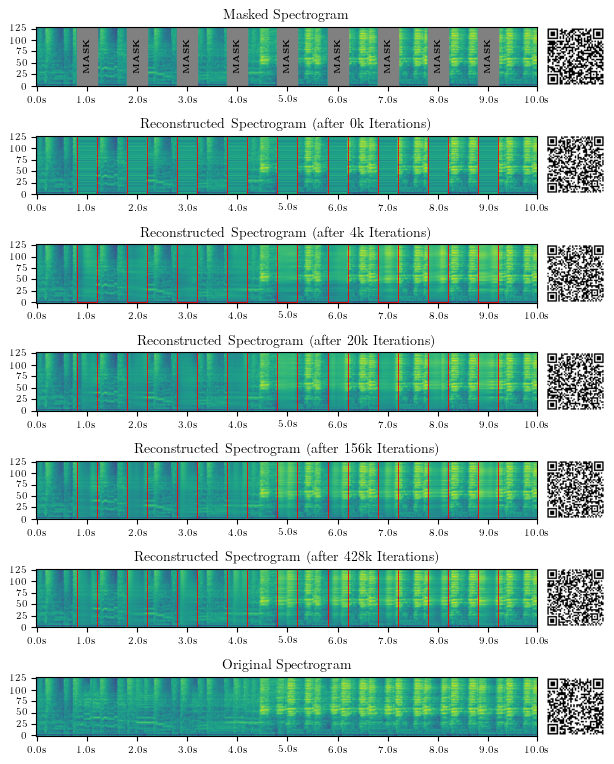

In [65]:
# Verify the file path is correct
#file_path = '/home/bosfab01/SpeakerVerificationBA/data/preprocessed/0a4b5c0f-facc-4d3b-8a41-bc9148d62d95/0_segment_0.flac'
file_path = '/home/bosfab01/SpeakerVerificationBA/data/preprocessed_eval/1a281f7d-bde7-4744-9220-7ea599b6e093/0_segment_0.flac'
try:
    audio_signal, sample_rate = sf.read(file_path)
except Exception as e:
    print(f"An error occurred while reading the file: {e}")
    raise

# Create time array for plotting
time = np.arange(len(audio_signal)) / sample_rate

# Convert the NumPy array to a PyTorch tensor
audio_tensor = torch.from_numpy(audio_signal)

# Ensure the tensor is in float32 format (required for most torchaudio operations)
audio_tensor = audio_tensor.float()

# If your array is not in batch x channels x time format, adjust accordingly
# Assuming the audio signal is single-channel and not batched:
audio_tensor = audio_tensor.unsqueeze(0)

# Now call the fbank function
fbank_features = torchaudio.compliance.kaldi.fbank(
    audio_tensor, 
    sample_frequency=sample_rate, 
    htk_compat=True, 
    use_energy=False, 
    window_type='hanning', 
    num_mel_bins=128, 
    dither=0.0, 
    frame_shift=10
)

# Output the shape of the fbank features to confirm
test_input = fbank_features

# normalize fbank features
dataset_mean=-3.6925695
dataset_std=4.020388
test_input = (test_input - dataset_mean) / (2 * dataset_std)

# add batch dimension
test_input = test_input.unsqueeze(0)

width = 20
hop_length = 50 # just for visualization, not the actual hop length used in the data preparation
hops = range(hop_length, 998//2 - width//2, hop_length)
mask_indices = [range(i-width//2, i + width//2) for i in hops]
mask_indices = [idx for group in mask_indices for idx in group]
print(mask_indices)

# turn indices from model basis [0, 499] to spectrogram basis [0, 998]
expanded_mask_indices = []
for idx in mask_indices:
    expanded_mask_indices.extend([2 * idx, 2 * idx + 1])  # Expanding indice

# Create a mask for the spectrogram
mask = torch.ones_like(test_input)
for idx in expanded_mask_indices:
    mask[0, idx, :] = 0  # Set the specific patches to 0

# Apply the mask to the input spectrogram
masked_spectrogram = test_input * mask

# turn into tensor
mask_indices = torch.tensor(mask_indices)

# Assuming 'test_input' is your spectrogram tensor
n_timesteps = test_input.shape[1]  # 998
time_per_step = 10 / 1000  # Example: if each step represents 10 ms (adjust based on your actual data setup)

# Creating time labels for every 100 steps (1 second if each step is 10 ms)
# round timesteps to next 100 and get the range
x_ticks = np.arange(0, n_timesteps, 100)
last_tick = int(np.ceil(n_timesteps / 100) * 100)
x_ticks = np.append(x_ticks, last_tick)
 # formatting time labels as strings in seconds
x_labels = [f"{x * time_per_step:.1f}s" for x in x_ticks]
x_ticks[-1] = n_timesteps


# y-ticks for the frequency axis
y_ticks = np.arange(0, 128, 25)


def initialize_model():
    return ASTModel(fshape=128, tshape=2, fstride=128, tstride=2, input_fdim=128, input_tdim=998, model_size='base', pretrain_stage=True)

def load_model(checkpoint_id):
    model = initialize_model()
    model = torch.nn.DataParallel(model)
    model.load_state_dict(torch.load(f'../pretraining/exp/pretrained-20240501-162648-original-base-f128-t2-b48-lr1e-4-m390-pretrain_joint-asli/models/audio_model.{checkpoint_id}.pth'))
    model = model.module
    model.to('cpu')
    model.eval()
    return model

# Load models
models = {i: load_model(i) for i in [1, 2, 6, 40, 108]}

# Generate spectrograms
with torch.no_grad():
    reconstructed_spectrograms = {i: model(test_input, task='visualize_mask', mask_indices=mask_indices) for i, model in models.items()}

# Plotting
plt.figure(figsize=(6.2, 7.7))

urls = [
    'https://github.com/Ironmomo/SpeakerVerificationBA/raw/master/plots_and_audios/audios/masked_music.wav',
    'https://github.com/Ironmomo/SpeakerVerificationBA/raw/master/plots_and_audios/audios/reconstructed_music_1.wav',
    'https://github.com/Ironmomo/SpeakerVerificationBA/raw/master/plots_and_audios/audios/reconstructed_music_2.wav',
    'https://github.com/Ironmomo/SpeakerVerificationBA/raw/master/plots_and_audios/audios/reconstructed_music_6.wav',
    'https://github.com/Ironmomo/SpeakerVerificationBA/raw/master/plots_and_audios/audios/reconstructed_music_40.wav',
    'https://github.com/Ironmomo/SpeakerVerificationBA/raw/master/plots_and_audios/audios/reconstructed_music_108.wav',
    'https://github.com/Ironmomo/SpeakerVerificationBA/raw/master/plots_and_audios/audios/original_music.wav'
]

# Generate QR codes and convert them to numpy arrays
qr_codes = []
for url in urls:
    qr = qrcode.QRCode(
        version=1,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=10,  # Reduced box size for fitting within plot
        border=1,  # Minimal border
    )
    qr.add_data(url)
    qr.make(fit=True)
    img = qr.make_image(fill_color='black', back_color='white').convert('L')
    qr_codes.append(np.array(img))
 

def plot_spectrogram(data, title, position):         
    plt.subplot(7, 1, position)
    plt.imshow(data[0].cpu().numpy().T, aspect='auto', origin='lower')
    plt.title(title)
    plt.xticks(x_ticks, x_labels)
    plt.yticks(y_ticks)
    #plt.xlabel('Time')
    #plt.ylabel('Mel Frequency Bins')

    # Place QR code within the same subplot on the right side
    # Inset axes: position, size of the inset axes within the main axes
    ax = plt.gca()
    inset_ax = ax.inset_axes([1.01, 0.0, 0.13, 1.0], transform=ax.transAxes)  # Adjust placement and size of the inset axes (where the QR code is placed) relative to the main axes (`ax`). They are normalized coordinates with values ranging from 0 to 1: [x-coordinate of lower left corner of inset axes, y-coordinate of lower left corner of inset axes, width of inset axes, height of inset axes]
    inset_ax.imshow(qr_codes[position-1], aspect='equal', cmap='gray')  # 'equal' keeps the aspect ratio of the QR code
    inset_ax.axis('off')  # Hide axis for cleaner look

def add_red_rectangles(ax, hops, patch_width, patch_height):
    for mid_index in hops:
        # Calculate the left corner of the rectangle
        left_corner = 2*mid_index - patch_width
        # Create a rectangle with no fill
        rect = patches.Rectangle((left_corner, 0), 2*patch_width, patch_height, linewidth=0.6, edgecolor='red', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

def add_gray_mask(ax, hops, patch_width, patch_height):
    for mid_index in hops:
        # Calculate the left corner of the rectangle
        left_corner = 2*mid_index - patch_width
        # Create a rectangle patch with gray color
        rect = patches.Rectangle((left_corner, 0), 2*patch_width, patch_height, linewidth=1, edgecolor='gray', facecolor='gray')  # semi-transparent
        # Add the patch to the Axes
        ax.add_patch(rect)
        
        # Add 'MASK' text at the center of the rectangle
        ax.text(left_corner + patch_width, patch_height / 2, r'\textbf{MASK}', horizontalalignment='center', verticalalignment='center', color='black', fontsize=6, rotation=90)


# masked spectrogram
plot_spectrogram(masked_spectrogram, 'Masked Spectrogram', 1)
add_gray_mask(plt.gca(), hops, width, test_input.shape[2])

# reconstructed spectrograms
for index, checkpoint in enumerate(sorted(reconstructed_spectrograms.keys())):
    plot_spectrogram(reconstructed_spectrograms[checkpoint], f'Reconstructed Spectrogram (after {(checkpoint-1)*4}k Iterations)', index + 2)
    add_red_rectangles(plt.gca(), hops, width, test_input.shape[2])

# original spectrogram
plot_spectrogram(test_input, 'Original Spectrogram', 7)
#add_red_rectangles(plt.gca(), hops, width, test_input.shape[2])

plt.tight_layout()

directory = 'plots'
if not os.path.exists(directory):
    os.makedirs(directory)
plt.savefig('plots/reconstructed_spectrogram_music.pdf')

plt.show()

### visualize masked speech with qr codes to listen to the audio files

#### model trained on original spectrograms

pretraining patch split stride: frequency=128, time=2
pretraining patch shape: frequency=128, time=2
pretraining patch array dimension: frequency=1, time=499
pretraining number of patches=499
input shape:  torch.Size([1, 1, 128, 998])
mask_dense shape:  torch.Size([1, 499, 768])
mask_embed shape:  torch.Size([1, 1, 768])
mask_tokens shape:  torch.Size([1, 499, 768])
x shape after masking:  torch.Size([1, 499, 768])
x shape after concatenating cls_tokens and dist_token:  torch.Size([1, 501, 768])
x shape after transformer layers:  torch.Size([1, 501, 768])
reconstructed_spectrogram shape:  torch.Size([1, 499, 256])
folded and transposed shape:  torch.Size([1, 128, 998])
torch.Size([1, 998, 128])
torch.Size([1, 998, 128])
x_ticks: [  0 100 200 300 400 500 600 700 800 900 998]
x_labels: ['0.0s', '1.0s', '2.0s', '3.0s', '4.0s', '5.0s', '6.0s', '7.0s', '8.0s', '9.0s', '10.0s']
masked_spectrogram shape: (128, 998)
reconstructed_spectrogram shape: (128, 998)
fbank_features shape: (128, 998)
e

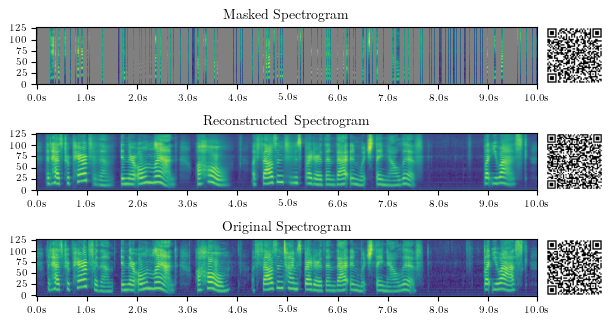

In [66]:
# Verify the file path is correct
file_path = '/home/bosfab01/SpeakerVerificationBA/data/preprocessed/0a4b5c0f-facc-4d3b-8a41-bc9148d62d95/0_segment_0.flac'
try:
    audio_signal, sample_rate = sf.read(file_path)
except Exception as e:
    print(f"An error occurred while reading the file: {e}")
    raise

directory = 'audios'
if not os.path.exists(directory):
    os.makedirs(directory)

# Create time array for plotting
time = np.arange(len(audio_signal)) / sample_rate

# Convert the NumPy array to a PyTorch tensor
audio_tensor = torch.from_numpy(audio_signal)

# Ensure the tensor is in float32 format (required for most torchaudio operations)
audio_tensor = audio_tensor.float()

# If your array is not in batch x channels x time format, adjust accordingly
# Assuming the audio signal is single-channel and not batched:
audio_tensor = audio_tensor.unsqueeze(0)

# Now call the fbank function
fbank_features = torchaudio.compliance.kaldi.fbank(
    audio_tensor, 
    sample_frequency=sample_rate, 
    htk_compat=True, 
    use_energy=False, 
    window_type='hanning', 
    num_mel_bins=128, 
    dither=0.0, 
    frame_shift=10
)

# normalize fbank features
dataset_mean=-5.0716844 
dataset_std=4.386603
fbank_features = (fbank_features - dataset_mean) / (2 * dataset_std)

# add batch dimension
fbank_features = fbank_features.unsqueeze(0)

model = ASTModel(fshape=128, tshape=2, fstride=128, tstride=2, input_fdim=128, input_tdim=998, model_size='base', pretrain_stage=True)
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load('../pretraining/exp/pretrained-20240501-162648-original-base-f128-t2-b48-lr1e-4-m390-pretrain_joint-asli/models/audio_model.108.pth'))
model = model.module
model.to('cpu')
model.eval()

# make 250 random indices in the range [0, 499], but using a seed for reproducibility
np.random.seed(15)
mask_indices = np.random.choice(499, 370, replace=False)

# turn indices from model basis [0, 499] to spectrogram basis [0, 998]
expanded_mask_indices = []
for idx in mask_indices:
    expanded_mask_indices.extend([2 * idx, 2 * idx + 1])  # Expanding indice

# Create a mask for the spectrogram
mask = torch.ones_like(fbank_features)
for idx in expanded_mask_indices:
    mask[0, idx, :] = 0  # Set the specific patches to 0

# Apply the mask to the input spectrogram
masked_spectrogram = fbank_features * mask

# turn into tensor
mask_indices = torch.tensor(mask_indices)

# Call the model
with torch.no_grad():
    reconstructed_spectrogram = model(fbank_features, task='visualize_mask', mask_indices=mask_indices)

# compare input and output
print(fbank_features.shape)
print(reconstructed_spectrogram.shape)

n_timesteps = fbank_features.shape[1]  # 998
time_per_step = 10 / 1000  # Example: if each step represents 10 ms (adjust based on your actual data setup)

# Creating time labels for every 100 steps (1 second if each step is 10 ms)
# round timesteps to next 100 and get the range
x_ticks = np.arange(0, n_timesteps, 100)
last_tick = int(np.ceil(n_timesteps / 100) * 100)
x_ticks = np.append(x_ticks, last_tick)
 # formatting time labels as strings in seconds
x_labels = [f"{x * time_per_step:.1f}s" for x in x_ticks]
x_ticks[-1] = n_timesteps

print("x_ticks:", x_ticks)
print("x_labels:", x_labels)

# y-ticks for the frequency axis
y_ticks = np.arange(0, 128, 25)

# Define the patch width and height
patch_height = fbank_features.shape[2]  # This is the vertical height of your spectrogram

# save tensor for later
fbank_features_torch = fbank_features

# create numpy arrays
masked_spectrogram = masked_spectrogram[0].cpu().numpy().T
reconstructed_spectrogram = reconstructed_spectrogram[0].cpu().numpy().T
fbank_features = fbank_features[0].cpu().numpy().T

# unnormalize
masked_spectrogram = masked_spectrogram * (2 * dataset_std) + dataset_mean
reconstructed_spectrogram = reconstructed_spectrogram * (2 * dataset_std) + dataset_mean
fbank_features = fbank_features * (2 * dataset_std) + dataset_mean

# print shapes
print("masked_spectrogram shape:", masked_spectrogram.shape)
print("reconstructed_spectrogram shape:", reconstructed_spectrogram.shape)
print("fbank_features shape:", fbank_features.shape)

def add_gray_masks(ax, expanded_mask_indices, patch_height):
    print("expanded_mask_indices:", expanded_mask_indices)
    for index in expanded_mask_indices:
        # Calculate the left corner of the rectangle
        left_corner = index
        # Create a rectangle patch with gray color and full height coverage
        rect = patches.Rectangle((left_corner-0.5, 0), width=1.0, height=1.0*patch_height, linewidth=0.0, edgecolor='gray', facecolor='gray', alpha=1.0)  # Adjust alpha for visibility
        # Add the patch to the Axes
        ax.add_patch(rect)


# Example URLs for audio files (replace with actual URLs)
urls = [
    'https://github.com/Ironmomo/SpeakerVerificationBA/raw/master/plots_and_audios/audios/masked_speech_random_masks_originalModel.wav',
    'https://github.com/Ironmomo/SpeakerVerificationBA/raw/master/plots_and_audios/audios/reconstructed_speech_random_masks_originalModel.wav',
    'https://github.com/Ironmomo/SpeakerVerificationBA/raw/master/plots_and_audios/audios/original_speech_random_masks_originalModel.wav'
]

# Generate QR codes and convert them to numpy arrays
qr_codes = []
for url in urls:
    qr = qrcode.QRCode(
        version=1,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=10,  # Reduced box size for fitting within plot
        border=1,  # Minimal border
    )
    qr.add_data(url)
    qr.make(fit=True)
    img = qr.make_image(fill_color='black', back_color='white').convert('L')
    qr_codes.append(np.array(img))

# Titles for each subplot
titles = ['Masked Spectrogram', 'Reconstructed Spectrogram', 'Original Spectrogram']

# Plotting spectrograms with QR codes
fig, axs = plt.subplots(3, 1, figsize=(6.2, 3.3))

spectrograms = [masked_spectrogram, reconstructed_spectrogram, fbank_features]

for i, (ax, spectrogram) in enumerate(zip(axs, spectrograms)):
    im = ax.imshow(spectrogram, aspect='auto', origin='lower')
    if i == 0:
        add_gray_masks(ax, expanded_mask_indices, fbank_features.shape[0])
    ax.set_title(titles[i])
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)
    ax.set_yticks(y_ticks)
    
    # Place QR code within the same subplot on the right side
    # Inset axes: position, size of the inset axes within the main axes
    inset_ax = ax.inset_axes([1.01, 0.0, 0.13, 1.0], transform=ax.transAxes)  # Adjust placement and size of the inset axes (where the QR code is placed) relative to the main axes (`ax`). They are normalized coordinates with values ranging from 0 to 1: [x-coordinate of lower left corner of inset axes, y-coordinate of lower left corner of inset axes, width of inset axes, height of inset axes]
    inset_ax.imshow(qr_codes[i], aspect='equal', cmap='gray')  # 'equal' keeps the aspect ratio of the QR code
    inset_ax.axis('off')  # Hide axis for cleaner look

    # # Add text to the right of the spectrogram
    # inset_ax_text = ax.inset_axes([1.0, 0.0, 0.07, 0.65], transform=ax.transAxes)
    # inset_ax_text.text(0.5, 0.5, r'\noindent $\leftarrow$ Listen\\to it here', fontsize=10, rotation=-90, transform=inset_ax_text.transAxes, verticalalignment='center', horizontalalignment='center', color='black')
    # inset_ax_text.axis('off')  # Hide axis for cleaner look

plt.tight_layout(rect=[0, 0, 1, 1])  # Adjust the rect to prevent QR codes from being cut off: [left boundary of layout box as fraction of figure width, bottom boundary of ", right boundary of ", top boundary of "]

# Save the figure as a PDF file
if not os.path.exists('plots'):
    os.makedirs('plots')
plt.savefig('plots/reconstructed_spectrogram_speech_originalModel_with_qr.pdf')

plt.show()

#### model trained on shuffled spectrograms

pretraining patch split stride: frequency=128, time=2
pretraining patch shape: frequency=128, time=2
pretraining patch array dimension: frequency=1, time=499
pretraining number of patches=499
input shape:  torch.Size([1, 1, 128, 998])
mask_dense shape:  torch.Size([1, 499, 768])
mask_embed shape:  torch.Size([1, 1, 768])
mask_tokens shape:  torch.Size([1, 499, 768])
x shape after masking:  torch.Size([1, 499, 768])
x shape after concatenating cls_tokens and dist_token:  torch.Size([1, 501, 768])
x shape after transformer layers:  torch.Size([1, 501, 768])
reconstructed_spectrogram shape:  torch.Size([1, 499, 256])
folded and transposed shape:  torch.Size([1, 128, 998])
torch.Size([1, 998, 128])
torch.Size([1, 998, 128])
x_ticks: [  0 100 200 300 400 500 600 700 800 900 998]
x_labels: ['0.0s', '1.0s', '2.0s', '3.0s', '4.0s', '5.0s', '6.0s', '7.0s', '8.0s', '9.0s', '10.0s']
masked_spectrogram shape: (128, 998)
reconstructed_spectrogram shape: (128, 998)
fbank_features shape: (128, 998)
e

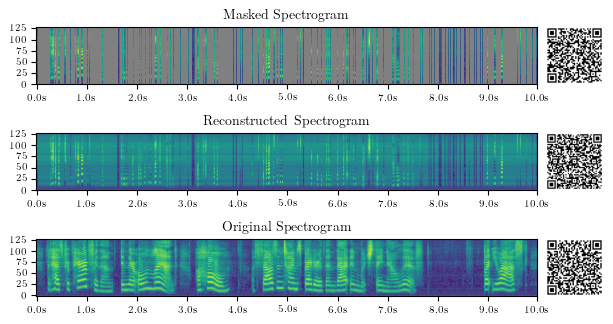

In [67]:
# Verify the file path is correct
file_path = '/home/bosfab01/SpeakerVerificationBA/data/preprocessed/0a4b5c0f-facc-4d3b-8a41-bc9148d62d95/0_segment_0.flac'
try:
    audio_signal, sample_rate = sf.read(file_path)
except Exception as e:
    print(f"An error occurred while reading the file: {e}")
    raise

directory = 'audios'
if not os.path.exists(directory):
    os.makedirs(directory)

# Create time array for plotting
time = np.arange(len(audio_signal)) / sample_rate

# Convert the NumPy array to a PyTorch tensor
audio_tensor = torch.from_numpy(audio_signal)

# Ensure the tensor is in float32 format (required for most torchaudio operations)
audio_tensor = audio_tensor.float()

# If your array is not in batch x channels x time format, adjust accordingly
# Assuming the audio signal is single-channel and not batched:
audio_tensor = audio_tensor.unsqueeze(0)

# Now call the fbank function
fbank_features = torchaudio.compliance.kaldi.fbank(
    audio_tensor, 
    sample_frequency=sample_rate, 
    htk_compat=True, 
    use_energy=False, 
    window_type='hanning', 
    num_mel_bins=128, 
    dither=0.0, 
    frame_shift=10
)

# normalize fbank features
dataset_mean=-5.0716844 
dataset_std=4.386603
fbank_features = (fbank_features - dataset_mean) / (2 * dataset_std)

# add batch dimension
fbank_features = fbank_features.unsqueeze(0)

model = ASTModel(fshape=128, tshape=2, fstride=128, tstride=2, input_fdim=128, input_tdim=998, model_size='base', pretrain_stage=True)
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load('../pretraining/exp/pretrained-20240429-112534-shuffled-base-f128-t2-b48-lr1e-4-m390-pretrain_joint-asli/models/audio_model.54.pth'))
model = model.module
model.to('cpu')
model.eval()

# make 250 random indices in the range [0, 499], but using a seed for reproducibility
np.random.seed(15)
mask_indices = np.random.choice(499, 370, replace=False)

# turn indices from model basis [0, 499] to spectrogram basis [0, 998]
expanded_mask_indices = []
for idx in mask_indices:
    expanded_mask_indices.extend([2 * idx, 2 * idx + 1])  # Expanding indice

# Create a mask for the spectrogram
mask = torch.ones_like(fbank_features)
for idx in expanded_mask_indices:
    mask[0, idx, :] = 0  # Set the specific patches to 0

# Apply the mask to the input spectrogram
masked_spectrogram = fbank_features * mask

# turn into tensor
mask_indices = torch.tensor(mask_indices)

# Call the model
with torch.no_grad():
    reconstructed_spectrogram = model(fbank_features, task='visualize_mask', mask_indices=mask_indices)

# compare input and output
print(fbank_features.shape)
print(reconstructed_spectrogram.shape)

n_timesteps = fbank_features.shape[1]  # 998
time_per_step = 10 / 1000  # Example: if each step represents 10 ms (adjust based on your actual data setup)

# Creating time labels for every 100 steps (1 second if each step is 10 ms)
# round timesteps to next 100 and get the range
x_ticks = np.arange(0, n_timesteps, 100)
last_tick = int(np.ceil(n_timesteps / 100) * 100)
x_ticks = np.append(x_ticks, last_tick)
 # formatting time labels as strings in seconds
x_labels = [f"{x * time_per_step:.1f}s" for x in x_ticks]
x_ticks[-1] = n_timesteps

print("x_ticks:", x_ticks)
print("x_labels:", x_labels)


# y-ticks for the frequency axis
y_ticks = np.arange(0, 128, 25)

# Define the patch width and height
patch_height = fbank_features.shape[2]  # This is the vertical height of your spectrogram

# save tensor for later
fbank_features_torch = fbank_features

# create numpy arrays
masked_spectrogram = masked_spectrogram[0].cpu().numpy().T
reconstructed_spectrogram = reconstructed_spectrogram[0].cpu().numpy().T
fbank_features = fbank_features[0].cpu().numpy().T

# unnormalize
masked_spectrogram = masked_spectrogram * (2 * dataset_std) + dataset_mean
reconstructed_spectrogram = reconstructed_spectrogram * (2 * dataset_std) + dataset_mean
fbank_features = fbank_features * (2 * dataset_std) + dataset_mean

# print shapes
print("masked_spectrogram shape:", masked_spectrogram.shape)
print("reconstructed_spectrogram shape:", reconstructed_spectrogram.shape)
print("fbank_features shape:", fbank_features.shape)

def add_gray_masks(ax, expanded_mask_indices, patch_height):
    print("expanded_mask_indices:", expanded_mask_indices)
    for index in expanded_mask_indices:
        # Calculate the left corner of the rectangle
        left_corner = index
        # Create a rectangle patch with gray color and full height coverage
        rect = patches.Rectangle((left_corner-0.5, 0), width=1.0, height=1.0*patch_height, linewidth=0.0, edgecolor='gray', facecolor='gray', alpha=1.0)  # Adjust alpha for visibility
        # Add the patch to the Axes
        ax.add_patch(rect)


# Example URLs for audio files (replace with actual URLs)
urls = [
    'https://github.com/Ironmomo/SpeakerVerificationBA/raw/master/plots_and_audios/audios/masked_speech_random_masks_shuffledModel.wav',
    'https://github.com/Ironmomo/SpeakerVerificationBA/raw/master/plots_and_audios/audios/reconstructed_speech_random_masks_shuffledModel.wav',
    'https://github.com/Ironmomo/SpeakerVerificationBA/raw/master/plots_and_audios/audios/original_speech_random_masks_shuffledModel.wav'
]

# Generate QR codes and convert them to numpy arrays
qr_codes = []
for url in urls:
    qr = qrcode.QRCode(
        version=1,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=10,  # Reduced box size for fitting within plot
        border=1,  # Minimal border
    )
    qr.add_data(url)
    qr.make(fit=True)
    img = qr.make_image(fill_color='black', back_color='white').convert('L')
    qr_codes.append(np.array(img))

# Titles for each subplot
titles = ['Masked Spectrogram', 'Reconstructed Spectrogram', 'Original Spectrogram']

# Plotting spectrograms with QR codes
fig, axs = plt.subplots(3, 1, figsize=(6.2, 3.3))

spectrograms = [masked_spectrogram, reconstructed_spectrogram, fbank_features]

for i, (ax, spectrogram) in enumerate(zip(axs, spectrograms)):
    im = ax.imshow(spectrogram, aspect='auto', origin='lower')
    if i == 0:
        add_gray_masks(ax, expanded_mask_indices, fbank_features.shape[0])
    ax.set_title(titles[i])
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)
    ax.set_yticks(y_ticks)
    
    # Place QR code within the same subplot on the right side
    # Inset axes: position, size of the inset axes within the main axes
    inset_ax = ax.inset_axes([1.01, 0.0, 0.13, 1.0], transform=ax.transAxes)  # Adjust placement and size of the inset axes (where the QR code is placed) relative to the main axes (`ax`). They are normalized coordinates with values ranging from 0 to 1: [x-coordinate of lower left corner of inset axes, y-coordinate of lower left corner of inset axes, width of inset axes, height of inset axes]
    inset_ax.imshow(qr_codes[i], aspect='equal', cmap='gray')  # 'equal' keeps the aspect ratio of the QR code
    inset_ax.axis('off')  # Hide axis for cleaner look

    # # Add text to the right of the spectrogram
    # inset_ax_text = ax.inset_axes([1.0, 0.0, 0.07, 0.65], transform=ax.transAxes)
    # inset_ax_text.text(0.5, 0.5, r'\noindent $\leftarrow$ Listen\\to it here', fontsize=10, rotation=-90, transform=inset_ax_text.transAxes, verticalalignment='center', horizontalalignment='center', color='black')
    # inset_ax_text.axis('off')  # Hide axis for cleaner look

plt.tight_layout(rect=[0, 0, 1, 1])  # Adjust the rect to prevent QR codes from being cut off: [left boundary of layout box as fraction of figure width, bottom boundary of ", right boundary of ", top boundary of "]

# Save the figure as a PDF file
if not os.path.exists('plots'):
    os.makedirs('plots')
plt.savefig('plots/reconstructed_spectrogram_speech_shuffledModel_with_qr.pdf')

plt.show()

check if it is actually the mean of the unmasked frames

expanded_mask_indices length: 740
expanded_mask_indices: [tensor(738), tensor(739), tensor(110), tensor(111), tensor(540), tensor(541), tensor(774), tensor(775), tensor(400), tensor(401), tensor(470), tensor(471), tensor(292), tensor(293), tensor(860), tensor(861), tensor(742), tensor(743), tensor(210), tensor(211), tensor(932), tensor(933), tensor(220), tensor(221), tensor(902), tensor(903), tensor(16), tensor(17), tensor(524), tensor(525), tensor(166), tensor(167), tensor(88), tensor(89), tensor(256), tensor(257), tensor(682), tensor(683), tensor(26), tensor(27), tensor(622), tensor(623), tensor(778), tensor(779), tensor(316), tensor(317), tensor(494), tensor(495), tensor(668), tensor(669), tensor(638), tensor(639), tensor(576), tensor(577), tensor(284), tensor(285), tensor(250), tensor(251), tensor(594), tensor(595), tensor(248), tensor(249), tensor(326), tensor(327), tensor(18), tensor(19), tensor(588), tensor(589), tensor(564), tensor(565), tensor(838), tensor(839), tensor(570), t

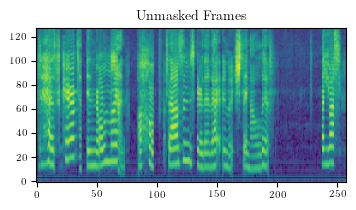

(128,)
random_indices: [274 773 369 497 736 669]


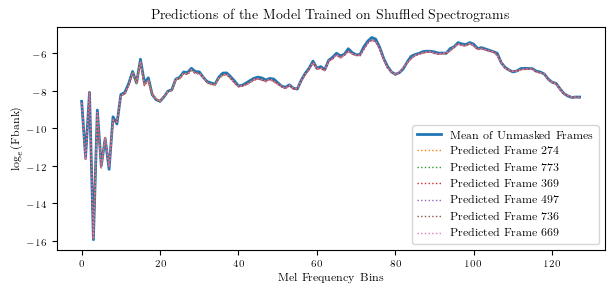

In [68]:
# turn indices from model basis [0, 499] to spectrogram basis [0, 998]
expanded_mask_indices = []
for idx in mask_indices:
    expanded_mask_indices.extend([2 * idx, 2 * idx + 1])  # Expanding indice

expanded_unmasked_indices = []
for idx in range(499):
    if idx not in mask_indices:
        expanded_unmasked_indices.extend([2 * idx, 2 * idx + 1])  # Expanding indice
    
print("expanded_mask_indices length:", len(expanded_mask_indices))
print("expanded_mask_indices:", expanded_mask_indices)
print("expanded_unmasked_indices length:", len(expanded_unmasked_indices))
print("expanded_unmasked_indices:", expanded_unmasked_indices)

# create spectrogram with only the unmasked frames
unmasked_frames = np.zeros((128, len(expanded_unmasked_indices)))
print(unmasked_frames.shape)

for i, idx in enumerate(expanded_unmasked_indices):
    unmasked_frames[:, i] = fbank_features[:, idx]

# plot the unmasked frames
plt.figure(figsize=(4, 2))
plt.imshow(unmasked_frames, aspect='auto', origin='lower')
plt.title('Unmasked Frames')
plt.show()

# calculate mean of frames and aggreagate into one 128x1 vector
mean_frames = np.mean(unmasked_frames, axis=1)
print(mean_frames.shape)

# randomly select 5 of the expanded mask indices with a seed for reproducibility
np.random.seed(25)
random_indices = np.random.choice(expanded_mask_indices, 6, replace=False)
print("random_indices:", random_indices)

plt.figure(figsize=(6.2, 3))
plt.plot(mean_frames, label='Mean of Unmasked Frames', linewidth=2)

for idx in random_indices:
    plt.plot(reconstructed_spectrogram[:, idx], label=f'Predicted Frame {idx}', linestyle='dotted', linewidth=1.0)

plt.legend()
plt.title('Predictions of the Model Trained on Shuffled Spectrograms')
plt.xlabel('Mel Frequency Bins')
plt.ylabel(r'$\log_e(\text{Fbank})$')  # Use raw string for LaTeX

plt.tight_layout()

plt.savefig('plots/predictedFrames_shuffled_spectrogram.pdf')

plt.show()


inspect the attention matrices